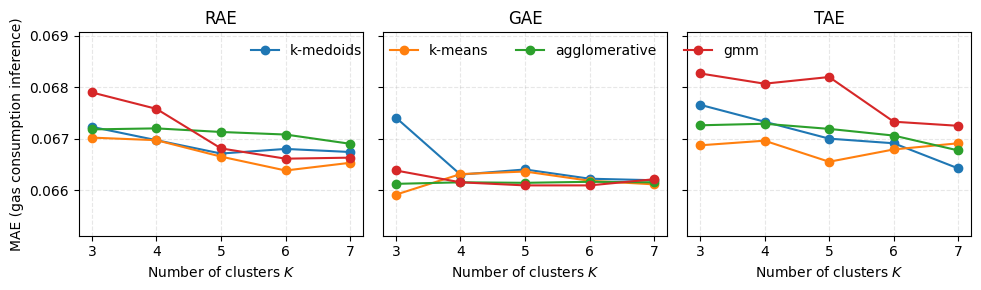

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 데이터 입력
K_vals = np.array([3, 4, 5, 6, 7])

data = {
    "RAE": {
        "k-medoids":     [0.06723, 0.06697, 0.06671, 0.06680, 0.06674],
        "k-means":       [0.06702, 0.06697, 0.06665, 0.06638, 0.06653],
        "agglomerative": [0.06718, 0.06720, 0.06713, 0.06708, 0.06690],
        "gmm":           [0.06790, 0.06758, 0.06681, 0.06661, 0.06663],
    },
    "GAE": {
        "k-medoids":     [0.06741, 0.06630, 0.06640, 0.06622, 0.06619],
        "k-means":       [0.06591, 0.06631, 0.06636, 0.06618, 0.06611],
        "agglomerative": [0.06612, 0.06615, 0.06614, 0.06616, 0.06615],
        "gmm":           [0.06638, 0.06615, 0.06609, 0.06609, 0.06621],
    },
    "TAE": {
        "k-medoids":     [0.06766, 0.06733, 0.06700, 0.06691, 0.06642],
        "k-means":       [0.06687, 0.06696, 0.06655, 0.06679, 0.06691],
        "agglomerative": [0.06726, 0.06729, 0.06719, 0.06706, 0.06677],
        "gmm":           [0.06827, 0.06807, 0.06820, 0.06733, 0.06725],
    },
}

encoders = ["RAE", "GAE", "TAE"]
methods  = ["k-medoids", "k-means", "agglomerative", "gmm"]

# 전체 y축 범위를 encoder/방법 전체에서 공통으로 잡기
all_vals = []
for enc in encoders:
    for m in methods:
        all_vals.extend(data[enc][m])
y_min = min(all_vals)
y_max = max(all_vals)
margin = 0.0008
ylim = (y_min - margin, y_max + margin)

# 그림 그리기
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

for ax, enc in zip(axes, encoders):
    for m in methods:
        ax.plot(K_vals, data[enc][m], marker="o", label=m)
    ax.set_title(enc)
    ax.set_xlabel("Number of clusters $K$")
    ax.set_ylim(ylim)
    ax.grid(True, linestyle="--", alpha=0.3)

axes[0].set_ylabel("MAE (gas consumption inference)")

# 하나의 범례만 공통으로
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=[0.25, 0.78], ncol=4, frameon=False)
# fig.suptitle("Sensitivity of gas-consumption inference to $K$ and clustering method", y=1.05)
plt.tight_layout()
plt.savefig("figures/cluster_sensitivity_lineplot.png", dpi=300)
plt.show()

=== Table: Statistical Analysis ===
                 Mean       Std  Skewness  Kurtosis  ADF Stat   p-value
Electricity  0.333535  0.080948  2.191381  6.475795 -3.376913  0.011772
Gas          0.004507  0.001937   0.40596 -0.940942 -5.248328  0.000007
Water        0.012674  0.003832  0.785061 -0.002903 -1.491958  0.537486
Hot Water    0.006591  0.002082  0.757755  0.277544 -1.895908  0.333989

=== LaTeX Code for Table ===
\begin{tabular}{lllllll}
\toprule
{} & Mean &  Std & Skewness & Kurtosis & ADF Stat & p-value \\
\midrule
Electricity & 0.33 & 0.08 &     2.19 &     6.48 &    -3.38 &    0.01 \\
Gas         & 0.00 & 0.00 &     0.41 &    -0.94 &    -5.25 &    0.00 \\
Water       & 0.01 & 0.00 &     0.79 &    -0.00 &    -1.49 &    0.54 \\
Hot Water   & 0.01 & 0.00 &     0.76 &     0.28 &    -1.90 &    0.33 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12965/1788094967.py:45: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_df.to_latex(float_format=lambda x: "%.2f" % x))



=== Figure Saved: energy_correlation_heatmap.png ===


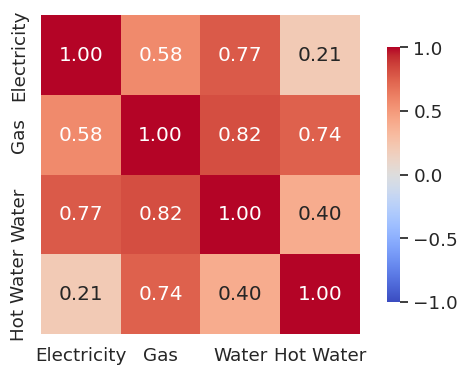

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# ---------------------------------------------------------
# 1. 데이터 로드 (사용자 환경에 맞게 수정 필요)
# ---------------------------------------------------------
elec = pd.read_csv('data/elec_clustering_train.csv', index_col=0, parse_dates=True).resample('12H').mean().mean(axis=1)
gas = pd.read_csv('data/gas_clustering_train.csv', index_col=0, parse_dates=True).resample('12H').mean().mean(axis=1)
hot_water = pd.read_csv('data/hotwater_clustering_train.csv', index_col=0, parse_dates=True).resample('12H').mean().mean(axis=1)
water = pd.read_csv('data/water_clustering_train.csv', index_col=0, parse_dates=True).resample('12H').mean().mean(axis=1)

data = pd.DataFrame({
    'Electricity': elec,
    'Gas': gas,
    'Water': water,
    'Hot Water': hot_water
},)

# ---------------------------------------------------------
# 2. 기술 통계 및 ADF 테스트 (Table 생성용)
# ---------------------------------------------------------
stats_df = pd.DataFrame(index=data.columns, 
                        columns=['Mean', 'Std', 'Skewness', 'Kurtosis', 'ADF Stat', 'p-value'])

for col in data.columns:
    series = data[col]
    # 기술 통계
    stats_df.loc[col, 'Mean'] = series.mean()
    stats_df.loc[col, 'Std'] = series.std()
    stats_df.loc[col, 'Skewness'] = series.skew()
    stats_df.loc[col, 'Kurtosis'] = series.kurtosis()
    
    # ADF Test (Stationarity)
    adf_result = adfuller(series.dropna())
    stats_df.loc[col, 'ADF Stat'] = adf_result[0]
    stats_df.loc[col, 'p-value'] = adf_result[1]

print("=== Table: Statistical Analysis ===")
print(stats_df)
# LaTeX 변환 (논문 삽입용)
print("\n=== LaTeX Code for Table ===")
print(stats_df.to_latex(float_format=lambda x: "%.2f" % x))

# ---------------------------------------------------------
# 3. 상관관계 분석 (Figure 생성용)
# ---------------------------------------------------------
plt.figure(figsize=(6, 4))
corr_matrix = data.corr(method='pearson')

# Heatmap 그리기
sns.set(font_scale=1.2)
heatmap = sns.heatmap(corr_matrix, 
                      annot=True, 
                      fmt=".2f", 
                      cmap='coolwarm', 
                      vmin=-1, vmax=1, 
                      square=True,
                      cbar_kws={"shrink": .8})

# plt.title('Pearson Correlation Matrix of Energy Sources (Reference Region)', fontsize=14)
plt.tight_layout()

# 파일 저장
plt.savefig('figures/energy_correlation_heatmap.png', dpi=300)
print("\n=== Figure Saved: energy_correlation_heatmap.png ===")
plt.show()

=== Figure Saved: energy_distribution_plots_clean.png ===


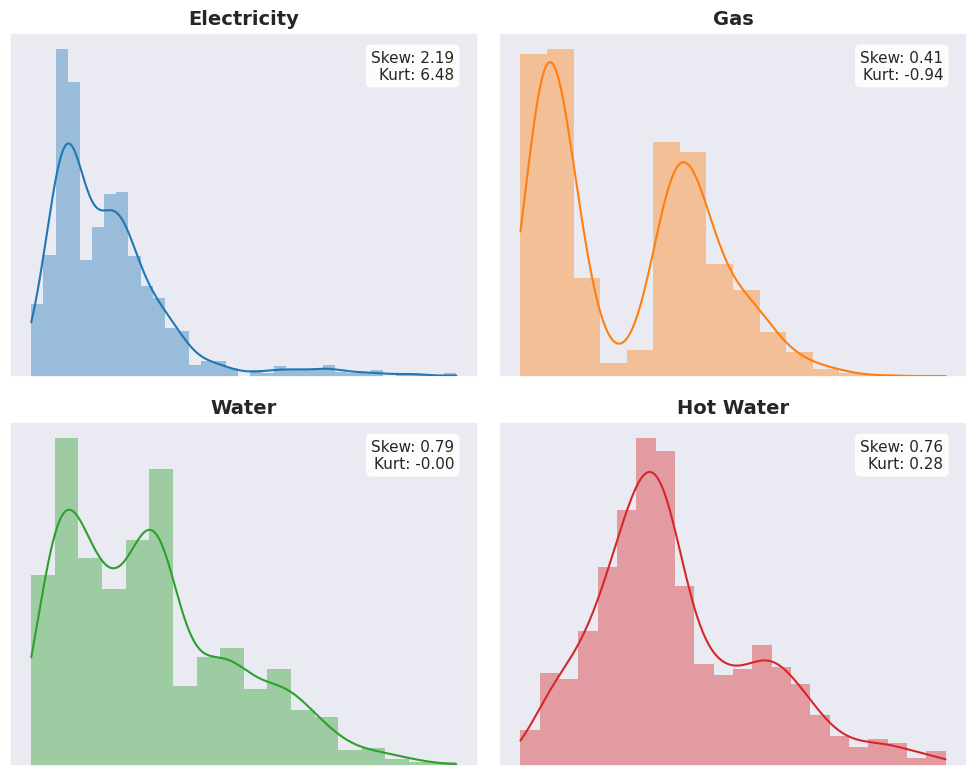

In [3]:
# ---------------------------------------------------------
# 분포도 그리기 (축 제거 버전)
# ---------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(10, 8)) # 크기 약간 조정
axes = axes.flatten()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, col in enumerate(data.columns):
    # 히스토그램 + KDE
    sns.histplot(data[col], kde=True, ax=axes[i], color=colors[i], stat="density", linewidth=0, alpha=0.4)
    
    # 왜도/첨도 계산
    skew_val = data[col].skew()
    kurt_val = data[col].kurtosis()
    
    # [수정] 타이틀만 남기고 축 라벨 및 눈금 제거
    axes[i].set_title(f'{col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('') # X축 라벨 제거
    axes[i].set_ylabel('') # Y축 라벨 제거
    axes[i].set_xticks([]) # X축 눈금 제거
    axes[i].set_yticks([]) # Y축 눈금 제거
    
    # 통계량 텍스트 (위치 조정)
    stats_text = f'Skew: {skew_val:.2f}\nKurt: {kurt_val:.2f}'
    axes[i].text(0.95, 0.95, stats_text, transform=axes[i].transAxes, 
                 fontsize=11, verticalalignment='top', horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

plt.tight_layout()
plt.savefig('figures/energy_distribution_plots_clean.png', dpi=300)
print("=== Figure Saved: energy_distribution_plots_clean.png ===")
plt.show()